In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

2024-02-05 17:27:08.574069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst

In [3]:
with gzip.open('../xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

In [4]:
congestion_data = np.load('../xbar/1/xbar_congestion.npz')
xbst = buildBST(congestion_data['xBoundaryList'])
ybst = buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])
congestion = np.zeros(shape = [instances.shape[0],])
capacity = np.zeros(shape = [instances.shape[0],])
layer = np.zeros(shape = [instances.shape[0],])

In [5]:
for k in range(instances.shape[0]):
    # print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    c = 0
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
        c += congestion_data['capacity'][lyr][i][j]
    demand[k] = d
    congestion[k] = d - c
    capacity[k] = c

instances['routing_demand'] = demand
instances['congestion'] = congestion
instances['capacity'] = capacity

In [6]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand,congestion,capacity
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,-8.0,28.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,-5.0,28.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,-10.0,33.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,-11.0,33.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,-2.0,23.0
...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,0.0,31.0
3948,U4125,3948,33664,66048,42,0,30.0,0.0,30.0
3949,U4128,3949,23296,66048,34,0,27.0,-2.0,29.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,-5.0,33.0


In [7]:
with gzip.open('../cells.json.gz','rb') as f:
    cells = json.loads(f.read().decode('utf-8'))

In [8]:
grc_pos = []
pin_count = []
for i in range(len(instances)):
    point = instances.loc[i]
    j = getGRCIndex(point.xloc,point.yloc,xbst,ybst)
    grc_pos.append(j)
    pin_count.append(len(cells[instances.loc[i].cell]['terms']))
instances['GRC_Index'] = grc_pos
instances['pin_count'] = pin_count
instances['pin_total'] = instances['pin_count'].groupby(instances['GRC_Index']).transform('sum')

In [9]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand,congestion,capacity,GRC_Index,pin_count,pin_total
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,-8.0,28.0,"(29, 27)",4,12
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,-5.0,28.0,"(31, 27)",4,8
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,-10.0,33.0,"(29, 28)",4,10
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,-11.0,33.0,"(31, 28)",4,8
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,-2.0,23.0,"(31, 29)",4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,0.0,31.0,"(35, 13)",3,12
3948,U4125,3948,33664,66048,42,0,30.0,0.0,30.0,"(43, 21)",3,16
3949,U4128,3949,23296,66048,34,0,27.0,-2.0,29.0,"(43, 14)",2,17
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,-5.0,33.0,"(29, 26)",2,12


In [10]:
instances.groupby(instances['GRC_Index'])['congestion'].mean()

GRC_Index
(1, 0)     -27.0
(1, 7)     -18.0
(1, 12)    -16.0
(1, 17)    -13.0
(1, 22)    -11.0
            ... 
(57, 38)   -22.0
(57, 43)   -22.0
(57, 48)   -23.0
(57, 49)   -24.0
(57, 54)   -35.0
Name: congestion, Length: 1300, dtype: float64

In [11]:
indexcongestion = instances.groupby(instances['GRC_Index'])['congestion'].mean()

In [12]:
xes = indexcongestion.index.str[0]
yes = indexcongestion.index.str[1]
vals = indexcongestion.values

In [13]:
a = instances['GRC_Index'].unique()
a.sort()
a

array([(1, 0), (1, 7), (1, 12), ..., (57, 48), (57, 49), (57, 54)],
      dtype=object)

In [14]:
instances[instances['congestion'] > 2]

,name,id,xloc,yloc,cell,orient,routing_demand,congestion,capacity,GRC_Index,pin_count,pin_total
649,U3894,649,62336,72192,9,6,33.0,4.0,29.0,"(47, 40)",5,15
719,U3976,719,29952,72192,9,0,30.0,3.0,27.0,"(47, 19)",5,25
1074,U4378,1074,30848,72192,9,6,30.0,3.0,27.0,"(47, 19)",5,25
2145,U5632,2145,30848,72192,9,0,30.0,3.0,27.0,"(47, 19)",5,25
2152,U5639,2152,29952,72192,46,4,30.0,3.0,27.0,"(47, 19)",5,25
2232,U5731,2232,63232,72192,46,6,33.0,4.0,29.0,"(47, 40)",5,15
2406,U5938,2406,29952,72192,9,6,30.0,3.0,27.0,"(47, 19)",5,25
3534,U7259,3534,62592,72192,46,0,33.0,4.0,29.0,"(47, 40)",5,15


<AxesSubplot:xlabel='xcoord', ylabel='ycoord'>

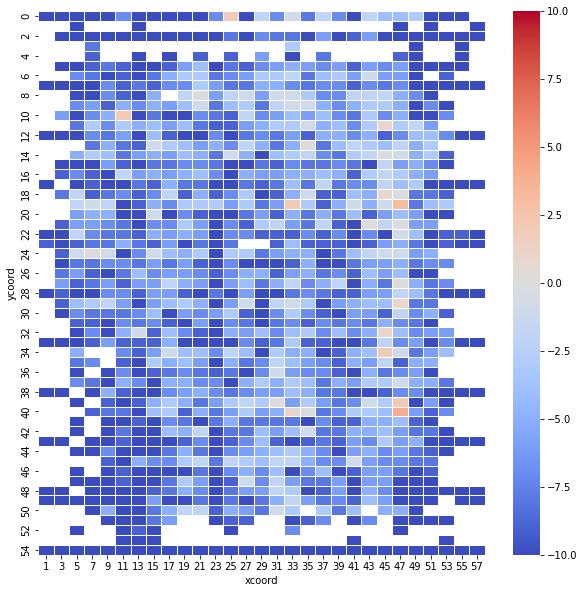

In [15]:
d = {'xcoord': list(xes),
'ycoord': list(yes),
'congestion': list(vals)}
df = pd.DataFrame(d)

min_congestion = -10
max_congestion = 10

plt.figure(figsize=(10, 10))
heatmap_data = df.pivot_table(index='ycoord', columns='xcoord', values='congestion', aggfunc='mean')
sns.heatmap(heatmap_data, vmin = min_congestion, vmax = max_congestion, cmap='coolwarm', fmt=".2f", linewidths=.5)

In [16]:
congestioncalc = congestion_data['demand'] - congestion_data['capacity']

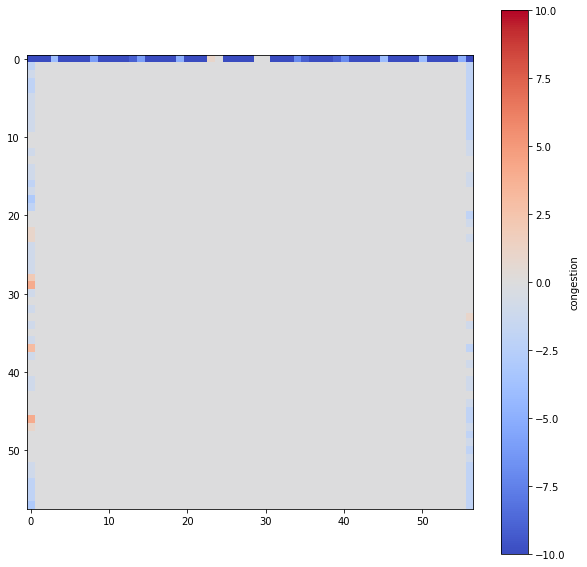

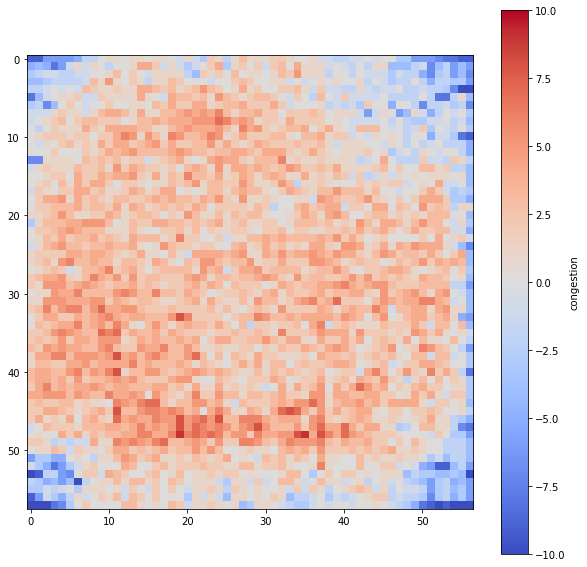

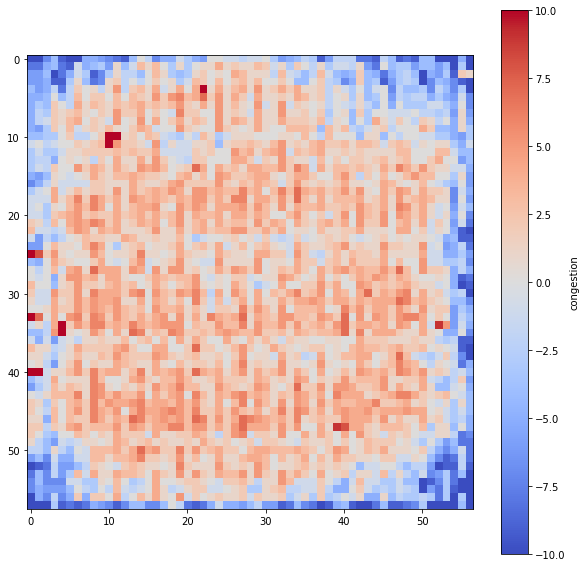

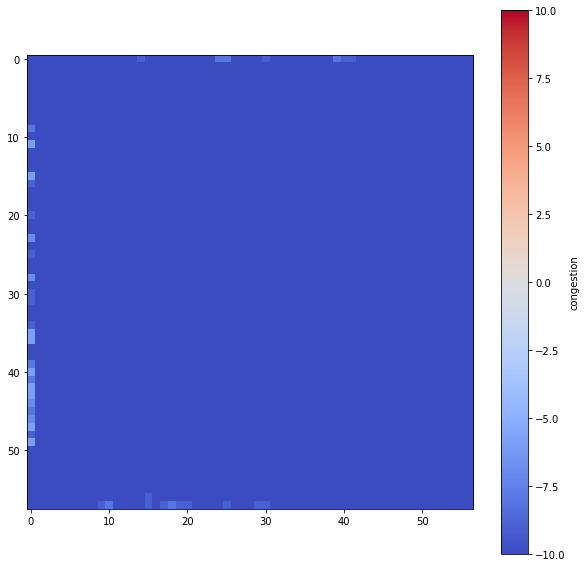

In [17]:
norm = mcolors.Normalize(vmin=min_congestion, vmax=max_congestion)
for i in range(4):
    plt.figure(figsize=(10, 10))
    heatmap = plt.imshow(congestioncalc[i], cmap = 'coolwarm', norm=norm, interpolation='nearest')
    colorbar = plt.colorbar(heatmap, label='congestion')
    plt.show()

In [18]:
conn=np.load('../xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T) #adjacency matrix
G = nx.from_numpy_array(A)